In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Load Company Metadata

In [2]:
co_data = pd.read_csv('/mnt/ext_stor/Revere/company_common.csv')

/home/bl/Documents/Research/Tonya/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (4,12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Get metadata for AMD

In [3]:
co_data.loc[co_data.ticker == 'AMD-US'].iloc[0]

start_                   Wed Aug 29 20:00:00 EDT 2018
end_                     Mon Oct 01 20:00:00 EDT 2018
id                                                194
name                       Advanced Micro Devices Inc
name_native_lang                                  NaN
active                                              Y
covered                                             Y
ticker                                         AMD-US
investor_contact_name                   Michael Haase
home_region                                        US
cusip                                       007903107
isin                                     US0079031078
sedol                                         2007849
valoren                                           NaN
eu_code                                           NaN
xs_code                                           NaN
profile_end_date         Sat Sep 29 20:00:00 EDT 2018
ticker_exchange                               AMD-NAS
Name: 2036460, dtype: object

In [4]:
del co_data

## Load Relationship Data

In [5]:
all_rels = pd.read_csv('/mnt/ext_stor/Revere/rels_start_end.csv')
all_rels['start_'] = pd.to_datetime(all_rels['start_'])
all_rels['end_'] = pd.to_datetime(all_rels['end_'])

In [6]:
all_rels.head()

,Unnamed: 0,start_,end_,supplier_id,customer_id
0,0,2003-04-03,2004-01-25,9840,12692
1,1,2003-04-03,2006-07-19,1090,4969
2,2,2003-04-03,2003-04-13,1399442,2939
3,3,2003-04-03,2004-01-11,8853,7384
4,4,2003-04-03,2005-05-04,180,5997


In [7]:
amd_rels = all_rels.loc[all_rels.customer_id == 194]
#amd_rels.rename({'supplier_id':'supplier_1_id'}, axis=1, inplace=True)

In [8]:
amd_rels.head()

,Unnamed: 0,start_,end_,supplier_id,customer_id
1073,1073,2003-04-03,2003-11-02,10377,194
1124,1124,2003-04-03,2004-02-15,9170,194
1640,1640,2003-04-03,2004-05-19,2937,194
3100,3100,2003-04-03,2003-07-27,8669,194
4273,4273,2003-04-03,2009-02-21,5178,194


In [9]:
n_tiers = 10

tier_one = amd_rels.copy()
tier_one['tier'] = 1
print('Tier {} has {} unique suppliers.'.format(1, len(tier_one.supplier_id.unique()) ))

tiers = [tier_one]
n_suppliers = [len(tier_one.supplier_id.unique())]

for i_tier in range(1,n_tiers):
    last_tier = tiers[-1].drop_duplicates(subset=['supplier_id'])[['supplier_id']]
    tier = pd.merge(last_tier, all_rels, left_on='supplier_id', right_on='customer_id', how='left')
    tier.drop(['supplier_id_x'], axis=1, inplace=True)
    tier.rename({'supplier_id_y':'supplier_id'}, axis=1, inplace=True)
    tier['tier'] = i_tier + 1
    tiers.append(tier)
    n_suppliers.append(len(tier.supplier_id.unique()))
    print('Tier {} has {} unique suppliers.'.format(i_tier+1, n_suppliers[-1]))

Tier 1 has 167 unique suppliers.
Tier 2 has 3935 unique suppliers.
Tier 3 has 20186 unique suppliers.
Tier 4 has 45366 unique suppliers.
Tier 5 has 57809 unique suppliers.
Tier 6 has 60513 unique suppliers.
Tier 7 has 61121 unique suppliers.
Tier 8 has 61195 unique suppliers.
Tier 9 has 61223 unique suppliers.
Tier 10 has 61225 unique suppliers.


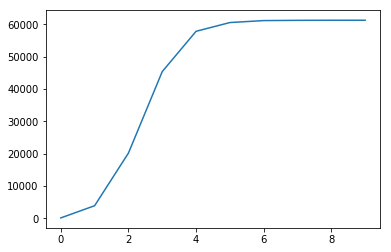

In [10]:
plt.plot(n_suppliers)

In [11]:
all_amd_suppliers = pd.concat(tiers)

In [12]:
all_amd_suppliers.shape

(6836601, 6)

In [13]:
point_in_time = '2017-01-01'

pit_sel = (all_amd_suppliers.start_ < point_in_time) & (all_amd_suppliers.end_ >= point_in_time)

pit_amd_sc = all_amd_suppliers.loc[pit_sel][['supplier_id', 'customer_id', 'tier']].drop_duplicates()

In [14]:
sup_by_tier = pit_amd_sc[['tier', 'supplier_id']].drop_duplicates().groupby(['tier']).count()

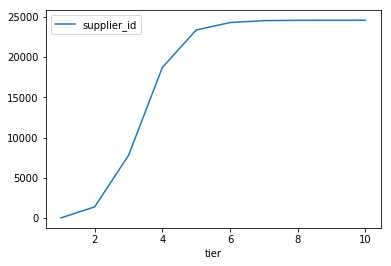

In [15]:
sup_by_tier.plot()

## Market Values

In [18]:
crsp_data = pd.read_csv('/mnt/ext_stor/crsp/m_stock/msf.csv')
crsp_data['DATE'] = pd.to_datetime(crsp_data['DATE'])

In [20]:
crsp_data.to_csv('/mnt/ext_stor/crsp/m_stock/msf.csv')

In [19]:
crsp_data.head()

,CUSIP,PERMNO,PERMCO,ISSUNO,HEXCD,HSICCD,DATE,BIDLO,ASKHI,PRC,...,RET,BID,ASK,SHROUT,CFACPR,CFACSHR,ALTPRC,SPREAD,ALTPRCDT,RETX
0,68391610,10000,7952,10396,3,3990.0,1985-12-31,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-2.5625,NaN,Mon Jan 06 19:00:00 EST 1986,NaN
1,68391610,10000,7952,10396,3,3990.0,1986-01-31,-2.50,-4.4375,-4.3750,...,NaN,NaN,NaN,3680.0,1.0,1.0,-4.3750,0.250,Thu Jan 30 19:00:00 EST 1986,NaN
2,68391610,10000,7952,10396,3,3990.0,1986-02-28,-3.25,-4.3750,-3.2500,...,-0.257143,NaN,NaN,3680.0,1.0,1.0,-3.2500,0.250,Thu Feb 27 19:00:00 EST 1986,-0.257143
3,68391610,10000,7952,10396,3,3990.0,1986-03-31,-3.25,-4.4375,-4.4375,...,0.365385,NaN,NaN,3680.0,1.0,1.0,-4.4375,0.125,Sun Mar 30 19:00:00 EST 1986,0.365385
4,68391610,10000,7952,10396,3,3990.0,1986-04-30,-4.00,-4.3125,-4.0000,...,-0.098592,NaN,NaN,3793.0,1.0,1.0,-4.0000,0.250,Tue Apr 29 20:00:00 EDT 1986,-0.098592


In [21]:
crsp_data['PRC'][crsp_data['PRC'] <= 0] = np.nan

/home/bl/Documents/Research/Tonya/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
crsp_data.columns

Index(['CUSIP', 'PERMNO', 'PERMCO', 'ISSUNO', 'HEXCD', 'HSICCD', 'DATE',
       'BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET', 'BID', 'ASK', 'SHROUT', 'CFACPR',
       'CFACSHR', 'ALTPRC', 'SPREAD', 'ALTPRCDT', 'RETX'],
      dtype='object')

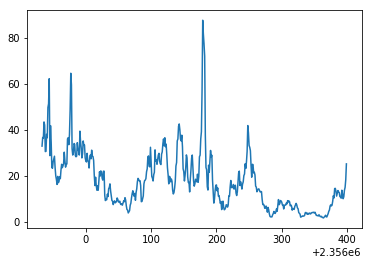

In [23]:
crsp_data.loc[crsp_data.CUSIP == '00790310'].PRC.plot()

## Institutional Ownership

In [2]:
s34type3 = pd.read_csv('/mnt/ext_stor/tfn/s34/s34type3.csv')

/home/bl/Documents/Research/Tonya/env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
s34type3['fdate'] = pd.to_datetime(s34type3.fdate)

In [ ]:
s34type3.to_csv('/mnt/ext_stor/tfn/s34/s34type3.csv')

In [26]:
s34type3.columns

Index(['fdate', 'cusip', 'mgrno', 'type', 'shares', 'sole', 'shared', 'no'], dtype='object')

In [6]:
s34type3.shape

(73558126, 8)

In [25]:
s34type3.loc[0, 'cusip'] == 80010

True

In [3]:
amd_ownership = s34type3.loc[s34type3.cusip == '00790310']

In [4]:
amd_ownership.shape

(28168, 8)

In [5]:
amd_ownership.head()

,fdate,cusip,mgrno,type,shares,sole,shared,no
4653115,Wed Mar 30 19:00:00 EST 1988,00790310,67480,1,500,NaN,NaN,NaN
4654581,Wed Mar 30 19:00:00 EST 1988,00790310,67740,5,4700,NaN,NaN,NaN
4655198,Wed Mar 30 19:00:00 EST 1988,00790310,67760,4,100000,NaN,NaN,NaN
4656045,Wed Mar 30 19:00:00 EST 1988,00790310,69100,1,35000,NaN,NaN,NaN
4657217,Wed Mar 30 19:00:00 EST 1988,00790310,70430,4,644200,NaN,NaN,NaN


In [34]:
s34type3.tail()

,fdate,cusip,mgrno,type,shares,sole,shared,no
73558121,Sat Dec 30 19:00:00 EST 2017,G5876H10,95105,5,179600,179600.0,0.0,0.0
73558122,Sat Dec 30 19:00:00 EST 2017,G8127610,95105,5,4700,4700.0,0.0,0.0
73558123,Sat Dec 30 19:00:00 EST 2017,G9319H10,95105,5,39239,39239.0,0.0,0.0
73558124,Sat Dec 30 19:00:00 EST 2017,H8817H10,95105,5,322280,322280.0,0.0,0.0
73558125,Sat Dec 30 19:00:00 EST 2017,V7780T10,95105,5,2000,2000.0,0.0,0.0


In [29]:
tier_one.shape

(167, 5)